<a href="https://colab.research.google.com/github/suhwankweon/Reinforcement_2023-2/blob/main/MountainCar_DQN_A68075_%EC%A1%B0%EC%95%84%EB%9D%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**[최종 선택 버전] epsilon decay + buffer limit 10만**
- 그래프 사이즈 조정 위해 재학습

[Gymnasium Environment : MountainCar-v0] 
- state_size : 2 
- action_size : 3

###### LEARNING ######
n_epi: 20, avg_score: -210.0 , n_buffer: 4179, eps: 9.9%
n_epi: 40, avg_score: -200.0 , n_buffer: 8159, eps: 9.8%
n_epi: 60, avg_score: -200.0 , n_buffer: 12139, eps: 9.7%
n_epi: 80, avg_score: -200.0 , n_buffer: 16119, eps: 9.6%
n_epi: 100, avg_score: -200.0 , n_buffer: 20099, eps: 9.5%
n_epi: 120, avg_score: -200.0 , n_buffer: 24079, eps: 9.4%
n_epi: 140, avg_score: -200.0 , n_buffer: 28059, eps: 9.3%
n_epi: 160, avg_score: -200.0 , n_buffer: 32039, eps: 9.2%
n_epi: 180, avg_score: -200.0 , n_buffer: 36019, eps: 9.1%
n_epi: 200, avg_score: -200.0 , n_buffer: 39999, eps: 9.0%
n_epi: 220, avg_score: -200.0 , n_buffer: 43979, eps: 8.9%
n_epi: 240, avg_score: -200.0 , n_buffer: 47959, eps: 8.8%
n_epi: 260, avg_score: -200.0 , n_buffer: 51939, eps: 8.7%
n_epi: 280, avg_score: -200.0 , n_buffer: 55919, eps: 8.6%
n_epi: 300, avg_score: -200.0 , n_buffer: 59899, eps: 8.5%
n_epi: 320, avg_sco

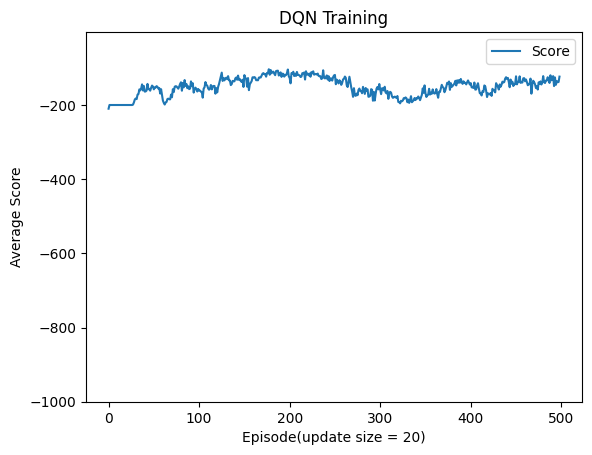


###### TEST ######
[TEST RESULT]
- Test 횟수: 1000
- Avg_reward : -133.488



In [ ]:
import gym as gym
import torch
import torch.nn as nn
import torch.nn.functional as F # 뉴런네트워크에서 주로 쓰는 함수들
import random
import numpy as np
import collections
import torch.optim as optim
import time
import matplotlib.pyplot as plt

#Hyperparameter
env_name = 'MountainCar-v0'
hidden_size = 128
learning_rate = 0.001
gamma = 0.98 #discount factor
buffer_limit = 100000 # replay buffer 사이즈
batch_size = 2000 #trangition 추출 사이즈 1천번은 학습이 너무 안되고 3천번은 에러가 남
eps = 0.1
eps_min = 0.01
eps_decay = 0.01
target_update = 20 # 업데이트 기준
episode_loop = 10000 # 트레이닝 횟수
test_episode = 1000 # 테스트

def environment():
  env = gym.make(env_name, new_step_api=True )  #, new_step_api=True

  # state, action size 확인하기
  state_size = env.observation_space.shape[0]
  action_size = env.action_space.n

  print("[Gymnasium Environment : {}] \n- state_size : {} \n- action_size : {}\n".format(env_name, state_size, action_size))
  return env, state_size, action_size


class DQN(nn.Module):
    def __init__(self, state_size, hidden_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size) # state space input
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size) # action space output

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        rv = random.random()
        if rv < epsilon:
            return random.randint(0,1)
        else:
            return out.argmax().item()


class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen = buffer_limit)

    def put(self, transition): #새로운 큐 넣기
        self.buffer.append(transition)

    def sample(self, n): #리플라이 버퍼에서 무작위 추출
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype = torch.float), torch.tensor(a_lst), torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), torch.tensor(done_mask_lst)

    def size(self):
        return len(self.buffer)


def train(q, q_target, memory, optimizer): # 현재 q와 target_q dqn학습
    for i in range(20):
        s, a, r, s_prime, done_mask = memory.sample(batch_size)
        q_out = q(s)  #현재 state의 q값
        q_a = q_out.gather(1, a)  #q값 선택
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)  #s_prime에서의 최대 큐값
        target = r + gamma * max_q_prime * done_mask  # 벨만방정식
        loss = F.mse_loss(q_a, target) # MSE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test(q, env, test_episode):
    test_total_reward = 0.0
    for episode in range(test_episode):
        s = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon=0.0)  # Greedy
            s, r, terminated , truncated, info = env.step(a)
            done = (terminated or truncated)
            test_total_reward += r

            if done:
              break
    avg_reward = test_total_reward / test_episode
    print("[TEST RESULT]\n- Test 횟수: {}\n- Avg_reward : {}\n".format(test_episode,avg_reward))


def main():
    env, state_size, action_size = environment()

    q = DQN(state_size, hidden_size, action_size)
    q_target = DQN(state_size, hidden_size, action_size)
    q_target.load_state_dict(q.state_dict()) # 현재 신경망의 가중치 복사
    memory = ReplayBuffer()  # 리플레이 버퍼 초기화
    optimizer = optim.Adam(q.parameters(), lr = learning_rate)
    score  = 0.0

    score_list = [] # update 주기 마다 평균 리워드 저장

    print("###### LEARNING ######")
    # 현재 시각 기록
    startTime = time.time()

    for n_epi in range(episode_loop):
        epsilon = max(eps_min, eps-eps_decay*(n_epi/200))
        s  = env.reset() # s,_ = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)
            s_prime, r, terminated , truncated, info = env.step(a)
            done = (terminated or truncated)
            done_mask = 0.0 if done else 1.0

            score += r

            if done:
                break

            memory.put((s, a, r/100.0 , s_prime, done_mask))
            s = s_prime

        if memory.size() > 2000:
            train(q, q_target, memory, optimizer)

        if (n_epi !=0) and (n_epi%target_update ==0):
            q_target.load_state_dict(q.state_dict())  # 학습한 현재 q-network의 q의 가중치 복사
            score_list.append(score/target_update)

            print("n_epi: {}, avg_score: {:.1f} , n_buffer: {}, eps: {:.1f}%".format(n_epi,score/target_update,  memory.size(), epsilon*100))
            score = 0.0

    # 경과 시간 체크
    exeTime = time.time() - startTime
    minutes, seconds = divmod(exeTime, 60)
    print("\n{}회 학습 완료(소요 시간 = {:.0f}분 {:.2f}초)".format(n_epi+1, minutes, seconds))

    # plt.figure(1, figsize=[10, 5]) 사이즈 조정 값
    # plt.figure(1, figsize=[10, 5]) 사이즈 조정 값
    plt.plot(score_list, label='Score')
    plt.ylim(-1000, max(score_list) + 100)  # 최소값을 -1000으로 설정

    plt.xlabel('Episode(update size = 20)')

    plt.ylabel('Average Score')
    plt.title('DQN Training')
    plt.legend()
    plt.show()  # 괄호 추가


    # main 함수 내에서 학습 후에 테스트 코드 추가
    print("\n###### TEST ######")
    test(q_target, env, test_episode)

    env.close()

if __name__ == '__main__':
    main()



[최종 버전] 기존 학습

[Gymnasium Environment : MountainCar-v0] 
- state_size : 2 
- action_size : 3

###### LEARNING ######


<ipython-input-1-2cd1b6cd1be7>:81: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(s_lst, dtype = torch.float), torch.tensor(a_lst), torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), torch.tensor(done_mask_lst)


n_epi: 20, avg_score: -210.0 , n_buffer: 4179, eps: 9.9%
n_epi: 40, avg_score: -200.0 , n_buffer: 8159, eps: 9.8%
n_epi: 60, avg_score: -200.0 , n_buffer: 12139, eps: 9.7%
n_epi: 80, avg_score: -200.0 , n_buffer: 16119, eps: 9.6%
n_epi: 100, avg_score: -200.0 , n_buffer: 20099, eps: 9.5%
n_epi: 120, avg_score: -200.0 , n_buffer: 24079, eps: 9.4%
n_epi: 140, avg_score: -200.0 , n_buffer: 28059, eps: 9.3%
n_epi: 160, avg_score: -200.0 , n_buffer: 32039, eps: 9.2%
n_epi: 180, avg_score: -200.0 , n_buffer: 36019, eps: 9.1%
n_epi: 200, avg_score: -200.0 , n_buffer: 39999, eps: 9.0%
n_epi: 220, avg_score: -200.0 , n_buffer: 43979, eps: 8.9%
n_epi: 240, avg_score: -200.0 , n_buffer: 47959, eps: 8.8%
n_epi: 260, avg_score: -200.0 , n_buffer: 51939, eps: 8.7%
n_epi: 280, avg_score: -200.0 , n_buffer: 55919, eps: 8.6%
n_epi: 300, avg_score: -200.0 , n_buffer: 59899, eps: 8.5%
n_epi: 320, avg_score: -200.0 , n_buffer: 63879, eps: 8.4%
n_epi: 340, avg_score: -200.0 , n_buffer: 67859, eps: 8.3%
n_e

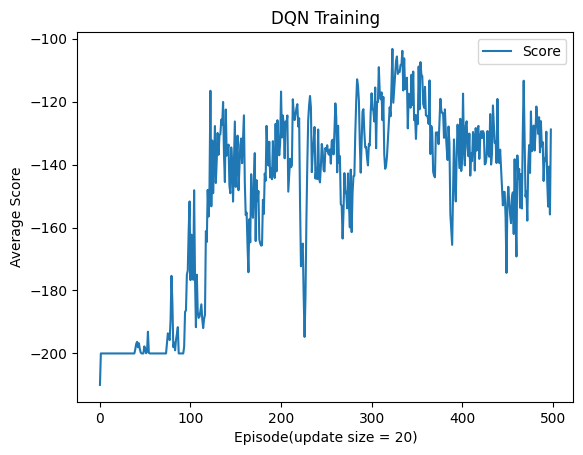

In [ ]:
import gym as gym
import torch
import torch.nn as nn
import torch.nn.functional as F # 뉴런네트워크에서 주로 쓰는 함수들
import random
import numpy as np
import collections
import torch.optim as optim
import time
import matplotlib.pyplot as plt

#Hyperparameter
env_name = 'MountainCar-v0'
hidden_size = 128
learning_rate = 0.001
gamma = 0.98 #discount factor
buffer_limit = 100000 # replay buffer 사이즈
batch_size = 2000 #trangition 추출 사이즈 1천번은 학습이 너무 안되고 3천번은 에러가 남
eps = 0.1
eps_min = 0.01
eps_decay = 0.01
target_update = 20 # 업데이트 기준
episode_loop = 10000 # 트레이닝 횟수
test_episode = 1000 # 테스트

def environment():
  env = gym.make(env_name, new_step_api=True )  #, new_step_api=True

  # state, action size 확인하기
  state_size = env.observation_space.shape[0]
  action_size = env.action_space.n

  print("[Gymnasium Environment : {}] \n- state_size : {} \n- action_size : {}\n".format(env_name, state_size, action_size))
  return env, state_size, action_size


class DQN(nn.Module):
    def __init__(self, state_size, hidden_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size) # state space input
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size) # action space output

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        rv = random.random()
        if rv < epsilon:
            return random.randint(0,1)
        else:
            return out.argmax().item()


class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen = buffer_limit)

    def put(self, transition): #새로운 큐 넣기
        self.buffer.append(transition)

    def sample(self, n): #리플라이 버퍼에서 무작위 추출
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype = torch.float), torch.tensor(a_lst), torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), torch.tensor(done_mask_lst)

    def size(self):
        return len(self.buffer)


def train(q, q_target, memory, optimizer): # 현재 q와 target_q dqn학습
    for i in range(20):
        s, a, r, s_prime, done_mask = memory.sample(batch_size)
        q_out = q(s)  #현재 state의 q값
        q_a = q_out.gather(1, a)  #q값 선택
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)  #s_prime에서의 최대 큐값
        target = r + gamma * max_q_prime * done_mask  # 벨만방정식
        loss = F.mse_loss(q_a, target) # MSE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test(q, env, test_episode):
    test_total_reward = 0.0
    for episode in range(test_episode):
        s = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon=0.0)  # Greedy
            s, r, terminated , truncated, info = env.step(a)
            done = (terminated or truncated)
            test_total_reward += r

            if done:
              break
    avg_reward = test_total_reward / test_episode
    print("[TEST RESULT]\n- Test 횟수: {}\n- Avg_reward : {}\n".format(test_episode,avg_reward))


def main():
    env, state_size, action_size = environment()

    q = DQN(state_size, hidden_size, action_size)
    q_target = DQN(state_size, hidden_size, action_size)
    q_target.load_state_dict(q.state_dict()) # 현재 신경망의 가중치 복사
    memory = ReplayBuffer()  # 리플레이 버퍼 초기화
    optimizer = optim.Adam(q.parameters(), lr = learning_rate)
    score  = 0.0

    score_list = [] # update 주기 마다 평균 리워드 저장

    print("###### LEARNING ######")
    # 현재 시각 기록
    startTime = time.time()

    for n_epi in range(episode_loop):
        epsilon = max(eps_min, eps-eps_decay*(n_epi/200))
        s  = env.reset() # s,_ = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)
            s_prime, r, terminated , truncated, info = env.step(a)
            done = (terminated or truncated)
            done_mask = 0.0 if done else 1.0

            score += r

            if done:
                break

            memory.put((s, a, r/100.0 , s_prime, done_mask))
            s = s_prime

        if memory.size() > 2000:
            train(q, q_target, memory, optimizer)

        if (n_epi !=0) and (n_epi%target_update ==0):
            q_target.load_state_dict(q.state_dict())  # 학습한 현재 q-network의 q의 가중치 복사
            score_list.append(score/target_update)

            print("n_epi: {}, avg_score: {:.1f} , n_buffer: {}, eps: {:.1f}%".format(n_epi,score/target_update,  memory.size(), epsilon*100))
            score = 0.0

    # 경과 시간 체크
    exeTime = time.time() - startTime
    minutes, seconds = divmod(exeTime, 60)
    print("\n{}회 학습 완료(소요 시간 = {:.0f}분 {:.2f}초)".format(n_epi+1, minutes, seconds))

    # plt.figure(1, figsize=[10, 5]) 사이즈 조정 값
    plt.plot(score_list, label='Score')
    plt.xlabel('Episode(update size = 20)')
    plt.ylabel('Average Score')
    plt.title('DQN Training')
    plt.legend()
    plt.show

    # main 함수 내에서 학습 후에 테스트 코드 추가
    print("\n###### TEST ######")
    test(q_target, env, test_episode)

    env.close()

if __name__ == '__main__':
    main()



**[base] epsilon decay + buffer limit 5만**

[Gymnasium Environment : MountainCar-v0] 
- state_size : 2 
- action_size : 3

###### LEARNING ######
n_epi: 20, avg_score: -210.0 , n_buffer: 4179, eps: 9.9%
n_epi: 40, avg_score: -200.0 , n_buffer: 8159, eps: 9.8%
n_epi: 60, avg_score: -200.0 , n_buffer: 12139, eps: 9.7%
n_epi: 80, avg_score: -200.0 , n_buffer: 16119, eps: 9.6%
n_epi: 100, avg_score: -200.0 , n_buffer: 20099, eps: 9.5%
n_epi: 120, avg_score: -200.0 , n_buffer: 24079, eps: 9.4%
n_epi: 140, avg_score: -200.0 , n_buffer: 28059, eps: 9.3%
n_epi: 160, avg_score: -200.0 , n_buffer: 32039, eps: 9.2%
n_epi: 180, avg_score: -200.0 , n_buffer: 36019, eps: 9.1%
n_epi: 200, avg_score: -200.0 , n_buffer: 39999, eps: 9.0%
n_epi: 220, avg_score: -200.0 , n_buffer: 43979, eps: 8.9%
n_epi: 240, avg_score: -200.0 , n_buffer: 47959, eps: 8.8%
n_epi: 260, avg_score: -200.0 , n_buffer: 50000, eps: 8.7%
n_epi: 280, avg_score: -200.0 , n_buffer: 50000, eps: 8.6%
n_epi: 300, avg_score: -200.0 , n_buffer: 50000, eps: 8.5%
n_epi: 320, avg_sco

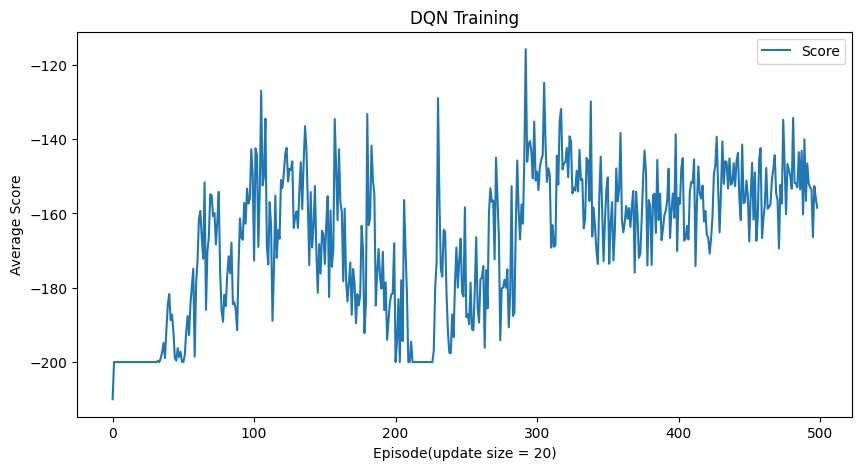

In [ ]:
import gym as gym
import torch
import torch.nn as nn
import torch.nn.functional as F # 뉴런네트워크에서 주로 쓰는 함수들
import random
import numpy as np
import collections
import torch.optim as optim
import time
import matplotlib.pyplot as plt

#Hyperparameter
env_name = 'MountainCar-v0'
hidden_size = 128
learning_rate = 0.001
gamma = 0.98 #discount factor
buffer_limit = 50000 # replay buffer 사이즈
batch_size = 2000 #trangition 추출 사이즈 1천번은 학습이 너무 안되고 3천번은 에러가 남
eps = 0.1
eps_min = 0.01
eps_decay = 0.01
target_update = 20 # 업데이트 기준
episode_loop = 10000 # 트레이닝 횟수
test_episode = 1000 # 테스트

def environment():
  env = gym.make(env_name, new_step_api=True )

  # state, action size 확인하기
  state_size = env.observation_space.shape[0]
  action_size = env.action_space.n

  print("[Gymnasium Environment : {}] \n- state_size : {} \n- action_size : {}\n".format(env_name, state_size, action_size))
  return env, state_size, action_size


class DQN(nn.Module):
    def __init__(self, state_size, hidden_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size) # state space input
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size) # action space output

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        rv = random.random()
        if rv < epsilon:
            return random.randint(0,1)
        else:
            return out.argmax().item()


class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen = buffer_limit)

    def put(self, transition): #새로운 큐 넣기
        self.buffer.append(transition)

    def sample(self, n): #리플라이 버퍼에서 무작위 추출
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype = torch.float), torch.tensor(a_lst), torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), torch.tensor(done_mask_lst)

    def size(self):
        return len(self.buffer)


def train(q, q_target, memory, optimizer): # 현재 q와 target_q dqn학습
    for i in range(20):
        s, a, r, s_prime, done_mask = memory.sample(batch_size)
        q_out = q(s)  #현재 state의 q값
        q_a = q_out.gather(1, a)  #q값 선택
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)  #s_prime에서의 최대 큐값
        target = r + gamma * max_q_prime * done_mask  # 벨만방정식
        loss = F.mse_loss(q_a, target) # MSE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test(q, env, test_episode):
    test_total_reward = 0.0
    for episode in range(test_episode):
        s = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon=0.0)  # Greedy
            s, r, terminated , truncated, info = env.step(a)
            done = (terminated or truncated)
            test_total_reward += r

            if done:
              break
    avg_reward = test_total_reward / test_episode
    print("[TEST RESULT]\n- Test 횟수: {}\n- Avg_reward : {}\n".format(test_episode,avg_reward))


def main():
    env, state_size, action_size = environment()

    q = DQN(state_size, hidden_size, action_size)
    q_target = DQN(state_size, hidden_size, action_size)
    q_target.load_state_dict(q.state_dict()) # 현재 신경망의 가중치 복사
    memory = ReplayBuffer()  # 리플레이 버퍼 초기화
    optimizer = optim.Adam(q.parameters(), lr = learning_rate)
    score  = 0.0

    score_list = [] # update 주기 마다 평균 리워드 저장

    print("###### LEARNING ######")
    # 현재 시각 기록
    startTime = time.time()

    for n_epi in range(episode_loop):
        epsilon = max(eps_min, eps-eps_decay*(n_epi/200))
        s  = env.reset() # s,_ = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)
            s_prime, r, terminated , truncated, info = env.step(a)
            done = (terminated or truncated)
            done_mask = 0.0 if done else 1.0

            score += r

            if done:
                break

            memory.put((s, a, r/100.0 , s_prime, done_mask))
            s = s_prime

        if memory.size() > 2000:
            train(q, q_target, memory, optimizer)

        if (n_epi !=0) and (n_epi%target_update ==0):
            q_target.load_state_dict(q.state_dict())  # 학습한 현재 q-network의 q의 가중치 복사
            score_list.append(score/target_update)

            print("n_epi: {}, avg_score: {:.1f} , n_buffer: {}, eps: {:.1f}%".format(n_epi,score/target_update,  memory.size(), epsilon*100))
            score = 0.0

    # 경과 시간 체크
    exeTime = time.time() - startTime
    minutes, seconds = divmod(exeTime, 60)
    print("\n{}회 학습 완료(소요 시간 = {:.0f}분 {:.2f}초)".format(n_epi+1, minutes, seconds))

    # plt.figure(1, figsize=[10, 5]) 사이즈 조정 값
    plt.plot(score_list, label='Score')
    plt.xlabel('Episode(update size = 20)')
    plt.ylabel('Average Score')
    plt.title('DQN Training')
    plt.legend()
    plt.show

    # main 함수 내에서 학습 후에 테스트 코드 추가
    print("\n###### TEST ######")
    test(q_target, env, test_episode)

    env.close()

if __name__ == '__main__':
    main()



**[Ver.1] epsilon decay+buffer limit 10만+batch size 64**

[Gymnasium Environment : MountainCar-v0] 
- state_size : 2 
- action_size : 3

###### LEARNING ######


<ipython-input-1-9c222b1ad002>:81: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(s_lst, dtype = torch.float), torch.tensor(a_lst), torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), torch.tensor(done_mask_lst)


n_epi: 20, avg_score: -210.0 , n_buffer: 4179, eps: 9.9%
n_epi: 40, avg_score: -200.0 , n_buffer: 8159, eps: 9.8%
n_epi: 60, avg_score: -200.0 , n_buffer: 12139, eps: 9.7%
n_epi: 80, avg_score: -200.0 , n_buffer: 16119, eps: 9.6%
n_epi: 100, avg_score: -200.0 , n_buffer: 20099, eps: 9.5%
n_epi: 120, avg_score: -200.0 , n_buffer: 24079, eps: 9.4%
n_epi: 140, avg_score: -200.0 , n_buffer: 28059, eps: 9.3%
n_epi: 160, avg_score: -200.0 , n_buffer: 32039, eps: 9.2%
n_epi: 180, avg_score: -200.0 , n_buffer: 36019, eps: 9.1%
n_epi: 200, avg_score: -200.0 , n_buffer: 39999, eps: 9.0%
n_epi: 220, avg_score: -200.0 , n_buffer: 43979, eps: 8.9%
n_epi: 240, avg_score: -200.0 , n_buffer: 47959, eps: 8.8%
n_epi: 260, avg_score: -200.0 , n_buffer: 51939, eps: 8.7%
n_epi: 280, avg_score: -200.0 , n_buffer: 55919, eps: 8.6%
n_epi: 300, avg_score: -200.0 , n_buffer: 59899, eps: 8.5%
n_epi: 320, avg_score: -200.0 , n_buffer: 63879, eps: 8.4%
n_epi: 340, avg_score: -200.0 , n_buffer: 67859, eps: 8.3%
n_e

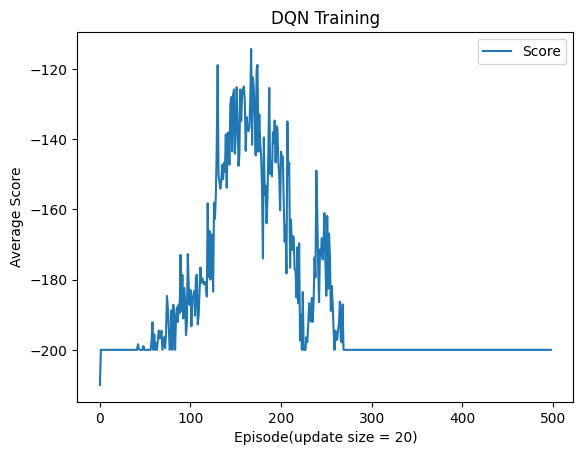

In [ ]:
import gym as gym
import torch
import torch.nn as nn
import torch.nn.functional as F # 뉴런네트워크에서 주로 쓰는 함수들
import random
import numpy as np
import collections
import torch.optim as optim
import time
import matplotlib.pyplot as plt

#Hyperparameter
env_name = 'MountainCar-v0'
hidden_size = 128
learning_rate = 0.001
gamma = 0.98 #discount factor
buffer_limit = 100000 # replay buffer 사이즈
batch_size = 64 #trangition 추출 사이즈 1천번은 학습이 너무 안되고 3천번은 에러가 남
eps = 0.1
eps_min = 0.01
eps_decay = 0.01
target_update = 20 # 업데이트 기준
episode_loop = 10000 # 트레이닝 횟수
test_episode = 1000 # 테스트

def environment():
  env = gym.make(env_name, new_step_api=True )  #, new_step_api=True

  # state, action size 확인하기
  state_size = env.observation_space.shape[0]
  action_size = env.action_space.n

  print("[Gymnasium Environment : {}] \n- state_size : {} \n- action_size : {}\n".format(env_name, state_size, action_size))
  return env, state_size, action_size


class DQN(nn.Module):
    def __init__(self, state_size, hidden_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size) # state space input
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size) # action space output

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        rv = random.random()
        if rv < epsilon:
            return random.randint(0,1)
        else:
            return out.argmax().item()


class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen = buffer_limit)

    def put(self, transition): #새로운 큐 넣기
        self.buffer.append(transition)

    def sample(self, n): #리플라이 버퍼에서 무작위 추출
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype = torch.float), torch.tensor(a_lst), torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), torch.tensor(done_mask_lst)

    def size(self):
        return len(self.buffer)


def train(q, q_target, memory, optimizer): # 현재 q와 target_q dqn학습
    for i in range(20):
        s, a, r, s_prime, done_mask = memory.sample(batch_size)
        q_out = q(s)  #현재 state의 q값
        q_a = q_out.gather(1, a)  #q값 선택
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)  #s_prime에서의 최대 큐값
        target = r + gamma * max_q_prime * done_mask  # 벨만방정식
        loss = F.mse_loss(q_a, target) # MSE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test(q, env, test_episode):
    test_total_reward = 0.0
    for episode in range(test_episode):
        s = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon=0.0)  # Greedy
            s, r, terminated , truncated, info = env.step(a)
            done = (terminated or truncated)
            test_total_reward += r

            if done:
              break
    avg_reward = test_total_reward / test_episode
    print("[TEST RESULT]\n- Test 횟수: {}\n- Avg_reward : {}\n".format(test_episode,avg_reward))


def main():
    env, state_size, action_size = environment()

    q = DQN(state_size, hidden_size, action_size)
    q_target = DQN(state_size, hidden_size, action_size)
    q_target.load_state_dict(q.state_dict()) # 현재 신경망의 가중치 복사
    memory = ReplayBuffer()  # 리플레이 버퍼 초기화
    optimizer = optim.Adam(q.parameters(), lr = learning_rate)
    score  = 0.0

    score_list = [] # update 주기 마다 평균 리워드 저장

    print("###### LEARNING ######")
    # 현재 시각 기록
    startTime = time.time()

    for n_epi in range(episode_loop):
        epsilon = max(eps_min, eps-eps_decay*(n_epi/200))
        s  = env.reset() # s,_ = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)
            s_prime, r, terminated , truncated, info = env.step(a)
            done = (terminated or truncated)
            done_mask = 0.0 if done else 1.0

            score += r

            if done:
                break

            memory.put((s, a, r/100.0 , s_prime, done_mask))
            s = s_prime

        if memory.size() > 2000:
            train(q, q_target, memory, optimizer)

        if (n_epi !=0) and (n_epi%target_update ==0):
            q_target.load_state_dict(q.state_dict())  # 학습한 현재 q-network의 q의 가중치 복사
            score_list.append(score/target_update)

            print("n_epi: {}, avg_score: {:.1f} , n_buffer: {}, eps: {:.1f}%".format(n_epi,score/target_update,  memory.size(), epsilon*100))
            score = 0.0

    # 경과 시간 체크
    exeTime = time.time() - startTime
    minutes, seconds = divmod(exeTime, 60)
    print("\n{}회 학습 완료(소요 시간 = {:.0f}분 {:.2f}초)".format(n_epi+1, minutes, seconds))

    # plt.figure(1, figsize=[10, 5]) 사이즈 조정 값
    plt.plot(score_list, label='Score')
    plt.xlabel('Episode(update size = 20)')
    plt.ylabel('Average Score')
    plt.title('DQN Training')
    plt.legend()
    plt.show

    # main 함수 내에서 학습 후에 테스트 코드 추가
    print("\n###### TEST ######")
    test(q_target, env, test_episode)

    env.close()

if __name__ == '__main__':
    main()



**[Ver.2] epsilon decay+target update 100**

[Gymnasium Environment : MountainCar-v0] 
- state_size : 2 
- action_size : 3

###### LEARNING ######


<ipython-input-1-7dcf8071eb4c>:81: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(s_lst, dtype = torch.float), torch.tensor(a_lst), torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), torch.tensor(done_mask_lst)


n_epi: 100, avg_score: -202.0 , n_buffer: 20099, eps: 9.5%
n_epi: 200, avg_score: -200.0 , n_buffer: 39999, eps: 9.0%
n_epi: 300, avg_score: -200.0 , n_buffer: 50000, eps: 8.5%
n_epi: 400, avg_score: -200.0 , n_buffer: 50000, eps: 8.0%
n_epi: 500, avg_score: -200.0 , n_buffer: 50000, eps: 7.5%
n_epi: 600, avg_score: -200.0 , n_buffer: 50000, eps: 7.0%
n_epi: 700, avg_score: -200.0 , n_buffer: 50000, eps: 6.5%
n_epi: 800, avg_score: -200.0 , n_buffer: 50000, eps: 6.0%
n_epi: 900, avg_score: -200.0 , n_buffer: 50000, eps: 5.5%
n_epi: 1000, avg_score: -200.0 , n_buffer: 50000, eps: 5.0%
n_epi: 1100, avg_score: -200.0 , n_buffer: 50000, eps: 4.5%
n_epi: 1200, avg_score: -200.0 , n_buffer: 50000, eps: 4.0%
n_epi: 1300, avg_score: -200.0 , n_buffer: 50000, eps: 3.5%
n_epi: 1400, avg_score: -200.0 , n_buffer: 50000, eps: 3.0%
n_epi: 1500, avg_score: -200.0 , n_buffer: 50000, eps: 2.5%
n_epi: 1600, avg_score: -199.9 , n_buffer: 50000, eps: 2.0%
n_epi: 1700, avg_score: -198.3 , n_buffer: 50000,

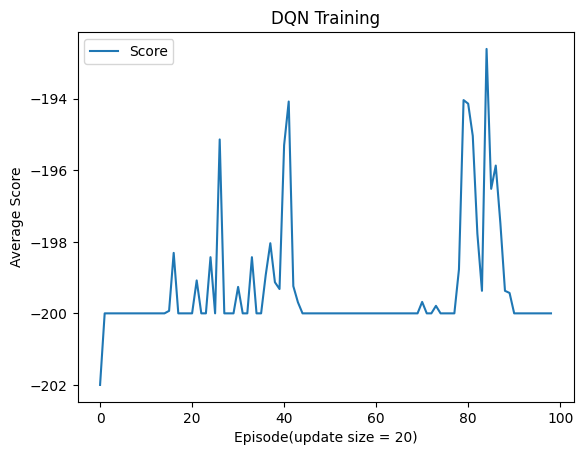

In [ ]:
import gym as gym
import torch
import torch.nn as nn
import torch.nn.functional as F # 뉴런네트워크에서 주로 쓰는 함수들
import random
import numpy as np
import collections
import torch.optim as optim
import time
import matplotlib.pyplot as plt

#Hyperparameter
env_name = 'MountainCar-v0'
hidden_size = 128
learning_rate = 0.001
gamma = 0.98 #discount factor
buffer_limit = 50000 # replay buffer 사이즈
batch_size = 2000 #trangition 추출 사이즈 1천번은 학습이 너무 안되고 3천번은 에러가 남
eps = 0.1
eps_min = 0.01
eps_decay = 0.01
target_update = 100 # 업데이트 기준
episode_loop = 10000 # 트레이닝 횟수
test_episode = 1000 # 테스트

def environment():
  env = gym.make(env_name, new_step_api=True )  #, new_step_api=True

  # state, action size 확인하기
  state_size = env.observation_space.shape[0]
  action_size = env.action_space.n

  print("[Gymnasium Environment : {}] \n- state_size : {} \n- action_size : {}\n".format(env_name, state_size, action_size))
  return env, state_size, action_size


class DQN(nn.Module):
    def __init__(self, state_size, hidden_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size) # state space input
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size) # action space output

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        rv = random.random()
        if rv < epsilon:
            return random.randint(0,1)
        else:
            return out.argmax().item()


class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen = buffer_limit)

    def put(self, transition): #새로운 큐 넣기
        self.buffer.append(transition)

    def sample(self, n): #리플라이 버퍼에서 무작위 추출
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype = torch.float), torch.tensor(a_lst), torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), torch.tensor(done_mask_lst)

    def size(self):
        return len(self.buffer)


def train(q, q_target, memory, optimizer): # 현재 q와 target_q dqn학습
    for i in range(20):
        s, a, r, s_prime, done_mask = memory.sample(batch_size)
        q_out = q(s)  #현재 state의 q값
        q_a = q_out.gather(1, a)  #q값 선택
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)  #s_prime에서의 최대 큐값
        target = r + gamma * max_q_prime * done_mask  # 벨만방정식
        loss = F.mse_loss(q_a, target) # MSE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test(q, env, test_episode):
    test_total_reward = 0.0
    for episode in range(test_episode):
        s = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon=0.0)  # Greedy
            s, r, terminated , truncated, info = env.step(a)
            done = (terminated or truncated)
            test_total_reward += r

            if done:
              break
    avg_reward = test_total_reward / test_episode
    print("[TEST RESULT]\n- Test 횟수: {}\n- Avg_reward : {}\n".format(test_episode,avg_reward))


def main():
    env, state_size, action_size = environment()

    q = DQN(state_size, hidden_size, action_size)
    q_target = DQN(state_size, hidden_size, action_size)
    q_target.load_state_dict(q.state_dict()) # 현재 신경망의 가중치 복사
    memory = ReplayBuffer()  # 리플레이 버퍼 초기화
    optimizer = optim.Adam(q.parameters(), lr = learning_rate)
    score  = 0.0

    score_list = [] # update 주기 마다 평균 리워드 저장

    print("###### LEARNING ######")
    # 현재 시각 기록
    startTime = time.time()

    for n_epi in range(episode_loop):
        epsilon = max(eps_min, eps-eps_decay*(n_epi/200))
        s  = env.reset() # s,_ = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)
            s_prime, r, terminated , truncated, info = env.step(a)
            done = (terminated or truncated)
            done_mask = 0.0 if done else 1.0

            score += r

            if done:
                break

            memory.put((s, a, r/100.0 , s_prime, done_mask))
            s = s_prime

        if memory.size() > 2000:
            train(q, q_target, memory, optimizer)

        if (n_epi !=0) and (n_epi%target_update ==0):
            q_target.load_state_dict(q.state_dict())  # 학습한 현재 q-network의 q의 가중치 복사
            score_list.append(score/target_update)

            print("n_epi: {}, avg_score: {:.1f} , n_buffer: {}, eps: {:.1f}%".format(n_epi,score/target_update,  memory.size(), epsilon*100))
            score = 0.0

    # 경과 시간 체크
    exeTime = time.time() - startTime
    minutes, seconds = divmod(exeTime, 60)
    print("\n{}회 학습 완료(소요 시간 = {:.0f}분 {:.2f}초)".format(n_epi+1, minutes, seconds))

    # plt.figure(1, figsize=[10, 5]) 사이즈 조정 값
    plt.plot(score_list, label='Score')
    plt.xlabel('Episode(update size = 20)')
    plt.ylabel('Average Score')
    plt.title('DQN Training')
    plt.legend()
    plt.show

    # main 함수 내에서 학습 후에 테스트 코드 추가
    print("\n###### TEST ######")
    test(q_target, env, test_episode)

    env.close()

if __name__ == '__main__':
    main()



**[Ver.3] epsilon 고정**

[Gymnasium Environment : MountainCar-v0] 
- state_size : 2 
- action_size : 3

###### LEARNING ######


<ipython-input-1-4d0ec7a34b4d>:81: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(s_lst, dtype = torch.float), torch.tensor(a_lst), torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), torch.tensor(done_mask_lst)


n_epi: 20, avg_score: -210.0 , n_buffer: 4179, eps: 10.0%
n_epi: 40, avg_score: -200.0 , n_buffer: 8159, eps: 10.0%
n_epi: 60, avg_score: -200.0 , n_buffer: 12139, eps: 10.0%
n_epi: 80, avg_score: -200.0 , n_buffer: 16119, eps: 10.0%
n_epi: 100, avg_score: -200.0 , n_buffer: 20099, eps: 10.0%
n_epi: 120, avg_score: -200.0 , n_buffer: 24079, eps: 10.0%
n_epi: 140, avg_score: -200.0 , n_buffer: 28059, eps: 10.0%
n_epi: 160, avg_score: -200.0 , n_buffer: 32039, eps: 10.0%
n_epi: 180, avg_score: -200.0 , n_buffer: 36019, eps: 10.0%
n_epi: 200, avg_score: -200.0 , n_buffer: 39999, eps: 10.0%
n_epi: 220, avg_score: -200.0 , n_buffer: 43979, eps: 10.0%
n_epi: 240, avg_score: -200.0 , n_buffer: 47959, eps: 10.0%
n_epi: 260, avg_score: -200.0 , n_buffer: 50000, eps: 10.0%
n_epi: 280, avg_score: -200.0 , n_buffer: 50000, eps: 10.0%
n_epi: 300, avg_score: -200.0 , n_buffer: 50000, eps: 10.0%
n_epi: 320, avg_score: -200.0 , n_buffer: 50000, eps: 10.0%
n_epi: 340, avg_score: -200.0 , n_buffer: 5000

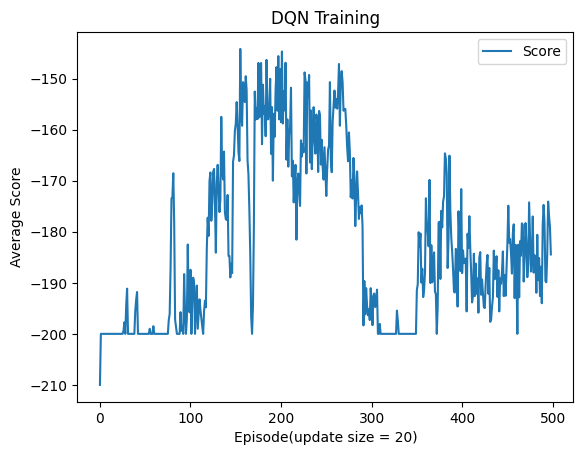

In [ ]:
import gym as gym
import torch
import torch.nn as nn
import torch.nn.functional as F # 뉴런네트워크에서 주로 쓰는 함수들
import random
import numpy as np
import collections
import torch.optim as optim
import time
import matplotlib.pyplot as plt

#Hyperparameter
env_name = 'MountainCar-v0'
hidden_size = 128
learning_rate = 0.001
gamma = 0.98 #discount factor
buffer_limit = 50000 # replay buffer 사이즈
batch_size = 2000 #trangition 추출 사이즈 1천번은 학습이 너무 안되고 3천번은 에러가 남
eps = 0.1
# eps_min = 0.01
# eps_decay = 0.01
target_update = 20 # 업데이트 기준
episode_loop = 10000 # 트레이닝 횟수
test_episode = 1000 # 테스트

def environment():
  env = gym.make(env_name, new_step_api=True )  #, new_step_api=True

  # state, action size 확인하기
  state_size = env.observation_space.shape[0]
  action_size = env.action_space.n

  print("[Gymnasium Environment : {}] \n- state_size : {} \n- action_size : {}\n".format(env_name, state_size, action_size))
  return env, state_size, action_size


class DQN(nn.Module):
    def __init__(self, state_size, hidden_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size) # state space input
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size) # action space output

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        rv = random.random()
        if rv < epsilon:
            return random.randint(0,1)
        else:
            return out.argmax().item()


class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen = buffer_limit)

    def put(self, transition): #새로운 큐 넣기
        self.buffer.append(transition)

    def sample(self, n): #리플라이 버퍼에서 무작위 추출
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype = torch.float), torch.tensor(a_lst), torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), torch.tensor(done_mask_lst)

    def size(self):
        return len(self.buffer)


def train(q, q_target, memory, optimizer): # 현재 q와 target_q dqn학습
    for i in range(20):
        s, a, r, s_prime, done_mask = memory.sample(batch_size)
        q_out = q(s)  #현재 state의 q값
        q_a = q_out.gather(1, a)  #q값 선택
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)  #s_prime에서의 최대 큐값
        target = r + gamma * max_q_prime * done_mask  # 벨만방정식
        loss = F.mse_loss(q_a, target) # MSE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test(q, env, test_episode):
    test_total_reward = 0.0
    for episode in range(test_episode):
        s = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon=0.0)  # Greedy
            s, r, terminated , truncated, info = env.step(a)
            done = (terminated or truncated)
            test_total_reward += r

            if done:
              break
    avg_reward = test_total_reward / test_episode
    print("[TEST RESULT]\n- Test 횟수: {}\n- Avg_reward : {}\n".format(test_episode,avg_reward))


def main():
    env, state_size, action_size = environment()

    q = DQN(state_size, hidden_size, action_size)
    q_target = DQN(state_size, hidden_size, action_size)
    q_target.load_state_dict(q.state_dict()) # 현재 신경망의 가중치 복사
    memory = ReplayBuffer()  # 리플레이 버퍼 초기화
    optimizer = optim.Adam(q.parameters(), lr = learning_rate)
    score  = 0.0

    score_list = [] # update 주기 마다 평균 리워드 저장

    print("###### LEARNING ######")
    # 현재 시각 기록
    startTime = time.time()

    for n_epi in range(episode_loop):
        # epsilon = max(eps_min, eps-eps_decay*(n_epi/200))
        epsilon = eps
        s  = env.reset() # s,_ = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)
            s_prime, r, terminated , truncated, info = env.step(a)
            done = (terminated or truncated)
            done_mask = 0.0 if done else 1.0

            score += r

            if done:
                break

            memory.put((s, a, r/100.0 , s_prime, done_mask))
            s = s_prime

        if memory.size() > 2000:
            train(q, q_target, memory, optimizer)

        if (n_epi !=0) and (n_epi%target_update ==0):
            q_target.load_state_dict(q.state_dict())  # 학습한 현재 q-network의 q의 가중치 복사
            score_list.append(score/target_update)

            print("n_epi: {}, avg_score: {:.1f} , n_buffer: {}, eps: {:.1f}%".format(n_epi,score/target_update,  memory.size(), epsilon*100))
            score = 0.0

    # 경과 시간 체크
    exeTime = time.time() - startTime
    minutes, seconds = divmod(exeTime, 60)
    print("\n{}회 학습 완료(소요 시간 = {:.0f}분 {:.2f}초)".format(n_epi+1, minutes, seconds))

    # plt.figure(1, figsize=[10, 5]) 사이즈 조정 값
    plt.plot(score_list, label='Score')
    plt.xlabel('Episode(update size = 20)')
    plt.ylabel('Average Score')
    plt.title('DQN Training')
    plt.legend()
    plt.show

    # main 함수 내에서 학습 후에 테스트 코드 추가
    print("\n###### TEST ######")
    test(q_target, env, test_episode)

    env.close()

if __name__ == '__main__':
    main()



**[Ver.4] epsilon decay+learning rate decay**

[Gymnasium Environment : MountainCar-v0] 
- state_size : 2 
- action_size : 3

###### LEARNING ######
n_epi: 20, avg_score: -210.0 , n_buffer: 4179, eps: 9.9%
n_epi: 40, avg_score: -200.0 , n_buffer: 8159, eps: 9.8%
n_epi: 60, avg_score: -200.0 , n_buffer: 12139, eps: 9.7%
n_epi: 80, avg_score: -200.0 , n_buffer: 16119, eps: 9.6%
n_epi: 100, avg_score: -200.0 , n_buffer: 20099, eps: 9.5%
n_epi: 120, avg_score: -200.0 , n_buffer: 24079, eps: 9.4%
n_epi: 140, avg_score: -200.0 , n_buffer: 28059, eps: 9.3%
n_epi: 160, avg_score: -200.0 , n_buffer: 32039, eps: 9.2%
n_epi: 180, avg_score: -200.0 , n_buffer: 36019, eps: 9.1%
n_epi: 200, avg_score: -200.0 , n_buffer: 39999, eps: 9.0%
n_epi: 220, avg_score: -200.0 , n_buffer: 43979, eps: 8.9%
n_epi: 240, avg_score: -200.0 , n_buffer: 47959, eps: 8.8%
n_epi: 260, avg_score: -200.0 , n_buffer: 50000, eps: 8.7%
n_epi: 280, avg_score: -200.0 , n_buffer: 50000, eps: 8.6%
n_epi: 300, avg_score: -200.0 , n_buffer: 50000, eps: 8.5%
n_epi: 320, avg_sco

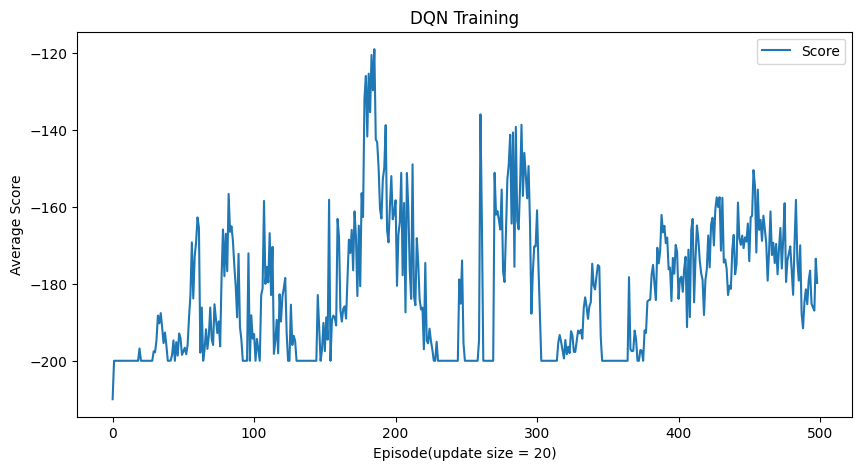

In [ ]:
#코랩에서 돌릴 때 env설정 시 워닝 문자가 나와서 수정해버림
#1.1만번 돌리고, 하이퍼링크 좀 더 수정 (최종버전)
# 러닝 레이트 디케이 적용
import gym as gym
import torch
import torch.nn as nn
import torch.nn.functional as F # 뉴런네트워크에서 주로 쓰는 함수들
import random
import numpy as np
import collections
import torch.optim as optim
import time
import matplotlib.pyplot as plt

#Hyperparameter
env_name = 'MountainCar-v0'
hidden_size = 128
learning_rate = 0.01 # decay 조정에 따라 여기도 변경 함
step_size = 200 # learning_rate decay / epsilon decay 모두 반영
gamma = 0.98 #discount factor, 벨만방정식, learning_rate decay 공식에 모두 반영 됨
buffer_limit = 50000 # replaiy buffer 사이즈
batch_size = 2000 #trangition 추출 사이즈 1천번은 학습이 너무 안되고 3천번은 에러가 남
eps = 0.1
eps_min = 0.01
eps_decay = 0.01
target_update = 20 # 업데이트 기준
episode_loop = 10000 # 트레이닝 횟수
test_episode = 1000 # 테스트

def environment():
  env = gym.make(env_name, new_step_api=True )  #, new_step_api=True

  # state, action size 확인하기
  state_size = env.observation_space.shape[0]
  action_size = env.action_space.n

  print("[Gymnasium Environment : {}] \n- state_size : {} \n- action_size : {}\n".format(env_name, state_size, action_size))
  return env, state_size, action_size


class DQN(nn.Module):
    def __init__(self, state_size, hidden_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size) # state space input
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size) # action space output

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        rv = random.random()
        if rv < epsilon:
            return random.randint(0,1)
        else:
            return out.argmax().item()


class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen = buffer_limit)

    def put(self, transition): #새로운 큐 넣기
        self.buffer.append(transition)

    def sample(self, n): #리플라이 버퍼에서 무작위 추출
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype = torch.float), torch.tensor(a_lst), torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), torch.tensor(done_mask_lst)

    def size(self):
        return len(self.buffer)


def train(q, q_target, memory, optimizer): # 현재 q와 target_q dqn학습
    for i in range(20):
        s, a, r, s_prime, done_mask = memory.sample(batch_size)
        q_out = q(s)  #현재 state의 q값
        q_a = q_out.gather(1, a)  #q값 선택
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)  #s_prime에서의 최대 큐값
        target = r + gamma * max_q_prime * done_mask  # 벨만방정식
        loss = F.mse_loss(q_a, target) # MSE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test(q, env, test_episode):
    test_total_reward = 0.0
    for episode in range(test_episode):
        s = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon=0.0)  # Greedy
            s, r, terminated , truncated, info = env.step(a)
            done = (terminated or truncated)
            test_total_reward += r

            if done:
              break
    avg_reward = test_total_reward / test_episode
    print("[TEST RESULT]\n- Test 횟수: {}\n- Avg_reward : {}\n".format(test_episode,avg_reward))


def main():
    env, state_size, action_size = environment()

    q = DQN(state_size, hidden_size, action_size)
    q_target = DQN(state_size, hidden_size, action_size)
    q_target.load_state_dict(q.state_dict()) # 현재 신경망의 가중치 복사
    memory = ReplayBuffer()  # 리플레이 버퍼 초기화
    optimizer = optim.Adam(q.parameters(), lr = learning_rate) #learning rate 초기 값

    #learning_rate decay 로직 적용
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma) # step_size에 따라 gamma(기존 discount factor 그대로 사용)의 비율로 감소

    score  = 0.0

    score_list = [] #에피소드 수행 시 마다 평균 리워드 저장

    print("###### LEARNING ######")
    # 현재 시각 기록
    startTime = time.time()

    for n_epi in range(episode_loop):
        #epsilon decay
        epsilon = max(eps_min, eps-(eps_decay*(n_epi/step_size)))
        s  = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)
            s_prime, r, terminated , truncated, info = env.step(a)
            done = (terminated or truncated)
            done_mask = 0.0 if done else 1.0

            score += r

            if done:
                break

            memory.put((s, a, r/100.0 , s_prime, done_mask))
            s = s_prime

        if memory.size() > 2000:
            train(q, q_target, memory, optimizer)

        if (n_epi !=0) and (n_epi%target_update ==0):
            q_target.load_state_dict(q.state_dict())  # 학습한 현재 q-network의 q의 가중치 복사
            score_list.append(score/target_update)

            print("n_epi: {}, avg_score: {:.1f} , n_buffer: {}, eps: {:.1f}%".format(n_epi,score/target_update,  memory.size(), epsilon*100))
            score = 0.0

        #learning rate decay 호출
        scheduler.step()

    # 경과 시간 체크
    exeTime = time.time() - startTime
    minutes, seconds = divmod(exeTime, 60)
    print("\n{}회 학습 완료(소요 시간 = {:.0f}분 {:.2f}초)".format(n_epi+1, minutes, seconds))

    plt.figure(1, figsize=[10, 5])
    plt.plot(score_list, label='Score')
    plt.xlabel('Episode(update size = 20)')
    plt.ylabel('Average Score')
    plt.title('DQN Training')
    plt.legend()
    plt.show

    # main 함수 내에서 학습 후에 테스트 코드 추가
    print("\n###### TEST ######")
    test(q_target, env, test_episode)

    env.close()

if __name__ == '__main__':
    main()



[별첨] double DQN 학습

[Gymnasium Environment : MountainCar-v0] 
- state_size : 2 
- action_size : 3

###### LEARNING ######
n_epi: 20, avg_score: -210.0 , n_buffer: 4179, eps: 9.9%
n_epi: 40, avg_score: -200.0 , n_buffer: 8159, eps: 9.8%
n_epi: 60, avg_score: -200.0 , n_buffer: 12139, eps: 9.7%
n_epi: 80, avg_score: -200.0 , n_buffer: 16119, eps: 9.6%
n_epi: 100, avg_score: -199.8 , n_buffer: 20096, eps: 9.5%
n_epi: 120, avg_score: -199.4 , n_buffer: 24064, eps: 9.4%
n_epi: 140, avg_score: -194.1 , n_buffer: 27926, eps: 9.3%
n_epi: 160, avg_score: -198.3 , n_buffer: 31872, eps: 9.2%
n_epi: 180, avg_score: -198.4 , n_buffer: 35821, eps: 9.1%
n_epi: 200, avg_score: -200.0 , n_buffer: 39801, eps: 9.0%
n_epi: 220, avg_score: -199.6 , n_buffer: 43772, eps: 8.9%
n_epi: 240, avg_score: -200.0 , n_buffer: 47752, eps: 8.8%
n_epi: 260, avg_score: -200.0 , n_buffer: 51732, eps: 8.7%
n_epi: 280, avg_score: -200.0 , n_buffer: 55712, eps: 8.6%
n_epi: 300, avg_score: -200.0 , n_buffer: 59692, eps: 8.5%
n_epi: 320, avg_sco

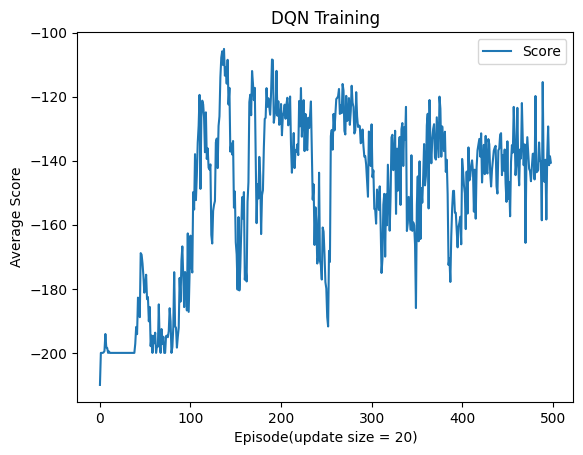

In [ ]:
import gym as gym
import torch
import torch.nn as nn
import torch.nn.functional as F # 뉴런네트워크에서 주로 쓰는 함수들
import random
import numpy as np
import collections
import torch.optim as optim
import time
import matplotlib.pyplot as plt

#Hyperparameter
env_name = 'MountainCar-v0'
hidden_size = 128
learning_rate = 0.001
gamma = 0.98 #discount factor
buffer_limit = 100000 # replay buffer 사이즈
batch_size = 2000 #trangition 추출 사이즈 1천번은 학습이 너무 안되고 3천번은 에러가 남
eps = 0.1
eps_min = 0.01
eps_decay = 0.01
target_update = 20 # 업데이트 기준
episode_loop = 10000 # 트레이닝 횟수
test_episode = 1000 # 테스트

def environment():
  env = gym.make(env_name, new_step_api=True )  #, new_step_api=True

  # state, action size 확인하기
  state_size = env.observation_space.shape[0]
  action_size = env.action_space.n

  print("[Gymnasium Environment : {}] \n- state_size : {} \n- action_size : {}\n".format(env_name, state_size, action_size))
  return env, state_size, action_size


class DQN(nn.Module):
    def __init__(self, state_size, hidden_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size) # state space input
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size) # action space output

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        rv = random.random()
        if rv < epsilon:
            return random.randint(0,1)
        else:
            return out.argmax().item()


class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen = buffer_limit)

    def put(self, transition): #새로운 큐 넣기
        self.buffer.append(transition)

    def sample(self, n): #리플라이 버퍼에서 무작위 추출
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype = torch.float), torch.tensor(a_lst), torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), torch.tensor(done_mask_lst)

    def size(self):
        return len(self.buffer)


def train(q, q_target, memory, optimizer): # 현재 q와 target_q dqn학습
    for i in range(20):
        s, a, r, s_prime, done_mask = memory.sample(batch_size)
        q_out = q(s)  #현재 state의 q값
        q_a = q_out.gather(1, a)  #q값 선택
        # max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)  #s_prime에서의 최대 큐값
        argmax_q = q(s_prime).max(1)[1].unsqueeze(1)
        max_q_prime = q_target(s_prime).gather(1, argmax_q)
        target = r + gamma * max_q_prime * done_mask  # 벨만방정식
        loss = F.mse_loss(q_a, target) # MSE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test(q, env, test_episode):
    test_total_reward = 0.0
    for episode in range(test_episode):
        s = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon=0.0)  # Greedy
            s, r, terminated , truncated, info = env.step(a)
            done = (terminated or truncated)
            test_total_reward += r

            if done:
              break
    avg_reward = test_total_reward / test_episode
    print("[TEST RESULT]\n- Test 횟수: {}\n- Avg_reward : {}\n".format(test_episode,avg_reward))


def main():
    env, state_size, action_size = environment()

    q = DQN(state_size, hidden_size, action_size)
    q_target = DQN(state_size, hidden_size, action_size)
    q_target.load_state_dict(q.state_dict()) # 현재 신경망의 가중치 복사
    memory = ReplayBuffer()  # 리플레이 버퍼 초기화
    optimizer = optim.Adam(q.parameters(), lr = learning_rate)
    score  = 0.0

    score_list = [] # update 주기 마다 평균 리워드 저장

    print("###### LEARNING ######")
    # 현재 시각 기록
    startTime = time.time()

    for n_epi in range(episode_loop):
        epsilon = max(eps_min, eps-eps_decay*(n_epi/200))
        s  = env.reset() # s,_ = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)
            s_prime, r, terminated , truncated, info = env.step(a)
            done = (terminated or truncated)
            done_mask = 0.0 if done else 1.0

            score += r

            if done:
                break

            memory.put((s, a, r/100.0 , s_prime, done_mask))
            s = s_prime

        if memory.size() > 2000:
            train(q, q_target, memory, optimizer)

        if (n_epi !=0) and (n_epi%target_update ==0):
            q_target.load_state_dict(q.state_dict())  # 학습한 현재 q-network의 q의 가중치 복사
            score_list.append(score/target_update)

            print("n_epi: {}, avg_score: {:.1f} , n_buffer: {}, eps: {:.1f}%".format(n_epi,score/target_update,  memory.size(), epsilon*100))
            score = 0.0

    # 경과 시간 체크
    exeTime = time.time() - startTime
    minutes, seconds = divmod(exeTime, 60)
    print("\n{}회 학습 완료(소요 시간 = {:.0f}분 {:.2f}초)".format(n_epi+1, minutes, seconds))

    # plt.figure(1, figsize=[10, 5]) 사이즈 조정 값
    plt.plot(score_list, label='Score')
    plt.xlabel('Episode(update size = 20)')
    plt.ylabel('Average Score')
    plt.title('DQN Training')
    plt.legend()
    plt.show

    # main 함수 내에서 학습 후에 테스트 코드 추가
    print("\n###### TEST ######")
    test(q_target, env, test_episode)

    env.close()

if __name__ == '__main__':
    main()

